In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from scipy.optimize import minimize
from scipy.spatial.distance import cdist, pdist
from scipy import stats
from sklearn.neighbors import DistanceMetric

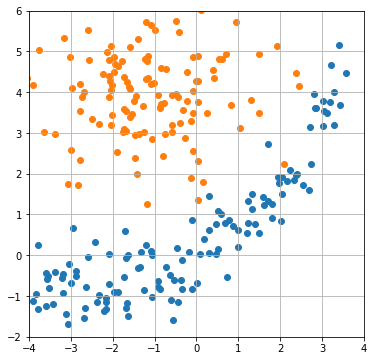

In [2]:
np.random.seed(0)
N = 125
x1 = np.linspace(-4,3.5,N).reshape(-1,1) + np.random.normal(0,0.1,N).reshape(-1,1)
y1 = np.exp(0.5*x1) - 1 + np.random.normal(0,0.6,N).reshape(-1,1)
x2 = np.random.normal(-1, 1.5, N).reshape(-1,1)
y2 = np.random.normal(4, 1, N).reshape(-1,1)

x_min = -4
x_max = 4
y_min = -2
y_max = 6

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x1,y1)
ax.scatter(x2,y2)
ax.set_xlim([x_min,x_max])
ax.set_ylim([y_min,y_max])
ax.grid()

In [3]:
# blue = 0, orange = 1
def colour(predict):
    if predict == 1.0:
        colour = 'Orange'
    elif predict == 0:
        colour = 'Blue'
    return colour

SVM classification accuracy:  0.984


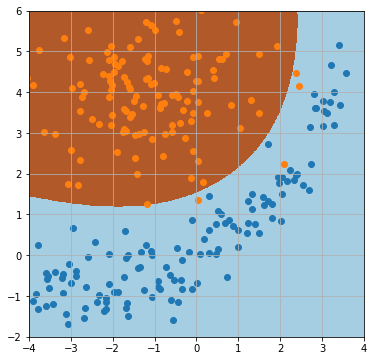

In [4]:
X = np.concatenate((np.concatenate((x1,x2)), np.concatenate((y1,y2))), axis=1)
Y = np.concatenate((np.zeros(N),np.ones(N)))

svm = SVC(gamma='scale', probability=True)
svm.fit(X,Y)
print('SVM classification accuracy: ',svm.score(X,Y))

h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots(figsize=(6,6))
ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
ax.scatter(x1,y1)
ax.scatter(x2,y2)
ax.set_xlim([x_min,x_max])
ax.set_ylim([y_min,y_max])
ax.grid()

In [5]:
# dataframe
data_df = pd.DataFrame(X,columns=['x', 'y'])
data_df['label'] = Y

In [6]:
def notgate(label):
    if label == 1:
        counter = 0
    elif label == 0:
        counter = 1
    return counter

def nearest(example, label, data):
    data_n = data[data['label']==int(label)]
    distances = dist.pairwise(data_n[['x','y']], example)
    data_n.insert(3, 'distances', distances, True)
    index_min = data_n.distances.idxmin()
    nearest_point = np.array([data_n.loc[index_min]['x'], data_n.loc[index_min]['y']]).reshape(1,-1)
    return nearest_point, index_min

def loss_function_l1norm(x_dash):
    L = 2*(logreg.predict(x_dash.reshape(1,-1)) - 1)**2 + \
    cdist(example, x_dash.reshape(1,-1), metric='cityblock')
    return L 

def dist_mad(cf, eg):
    manhat = [cdist(eg.T, cf.reshape(1,-1).T ,metric='cityblock')[i][i] for i in range(len(eg.T))]
    mad = stats.median_absolute_deviation(X)
    return sum(manhat/mad)

def loss_function_mad(x_dash):
    target = notgate(example_label)
    L = lamda*(svm.predict_proba(x_dash.reshape(1,-1))[0][target] - 1)**2 + \
    dist_mad(x_dash.reshape(1,-1), example)
    return L

In [15]:
x_value = -3
y_value = -1

example = np.array([x_value,y_value]).reshape(1,-1)
example_label = svm.predict(example)
print(colour(example_label))

Blue


In [16]:
# nearest neighbour
dist = DistanceMetric.get_metric('euclidean')
cf_nn, i = nearest(example, notgate(example_label), data_df)

while int(svm.predict(cf_nn)) != notgate(example_label):
    data_input = data_df.drop([i])
    cf_nn, i = nearest(example, notgate(example_label), data_input)
    
print(cf_nn)
colour(svm.predict(cf_nn))

[[-2.8211161   1.71137996]]


'Orange'

In [21]:
pred_threshold = 0.95

# initial conditions
lamda = 0.1 
x0 = np.array([1,1]).reshape(1,-1) # initial guess for cf

res = minimize(loss_function_mad, x0, method='nelder-mead', options={'maxiter':1000, 'xatol': 1e-8})
cf = res.x.reshape(1, -1)

target = notgate(example_label)
prob_target = svm.predict_proba(cf)[0][target]

i=0
while prob_target < pred_threshold:
    lamda += 0.1
    x0 = cf # starting point is current cf
    res = minimize(loss_function_mad, x0, method='nelder-mead', options={'maxiter':1000, 'xatol': 1e-8})
    cf = res.x.reshape(1, -1)
    prob_target = svm.predict_proba(cf)[0][target]
    i += 1
    if i == 3000:
        print('Error condition not met after',i,'iterations')
        break
                
print('Iterations: ',i)
print('Counterfactual point: ',cf[0])
print('Prediction: ',colour(svm.predict(cf)),'with probability',100*svm.predict_proba(cf)[0].max(),'%')

Iterations:  426
Counterfactual point:  [-3.          1.99480713]
Prediction:  Orange with probability 96.36611022455864 %


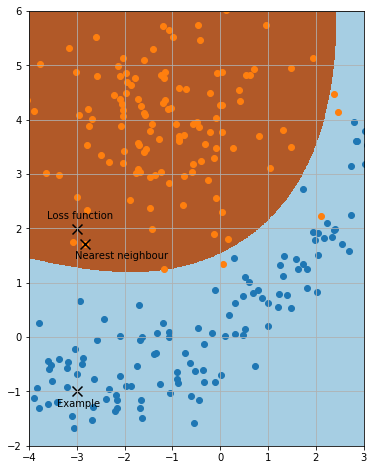

In [24]:
fig, ax = plt.subplots(figsize=(6, 8))
ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
ax.scatter(x1,y1)
ax.scatter(x2,y2)

ax.scatter(example[0][0],example[0][1], s=100, c='black', marker='x')
ax.annotate('Example', xy = (example[0][0],example[0][1]), xytext = (-20, -15), textcoords = 'offset points')

ax.scatter(cf[0][0],cf[0][1], s=100, c='black', marker='x')
ax.annotate('Loss function', xy = (cf[0][0],cf[0][1]), xytext = (-30, 10), textcoords = 'offset points')

ax.scatter(cf_nn[0][0],cf_nn[0][1], s=100, c='black', marker='x')
ax.annotate('Nearest neighbour', xy = (cf_nn[0][0],cf_nn[0][1]), xytext = (-10, -15), textcoords = 'offset points')

ax.set_xlim([x_min,x_max-1])
ax.set_ylim([y_min,y_max])
ax.grid()

fig.savefig('wachter.png')